# 传统滴水算法-字符分割

![classical-big-fall-truth-table-0410.jpg](./image/classical-big-fall-truth-table-0410.jpg)

## 概要
本篇介绍的传统滴水算法，字符分割部分，完全遵循了原文作者在论文中描述的分割逻辑．
**Segmentation of Numeric Strings**　G. Congedo, G. Dimauro, S . Impedovo, G. Pirlo, 毫不夸张的说，这篇教程是目前国内外，介绍传统滴水算法，最通俗易懂跟完备的教程．阿凯在搜索这方面的资料的时候大费周章，基本上找不到博客跟详细的参考资料，所以只能去啃论文．其实看论文有时候也是最高效的．




## 滴水算法介绍

滴水算法，如其名，算法参考了雨滴的智慧，黑色区域如同空旷的天空，连在一起的字符就像连在一起的两个房屋．　水滴从天空中掉落，顺着缝隙向下流淌，如果他们遇到了困难不能继续下落，就冲破禁锢，水滴石穿，打开缺口向下渗透，直至滑落出画面．　整个过程形成的轨迹，就是两个字符之间的分割线．不同于我们之前介绍的柱状图分割法滴水算法的分割线可以非常灵活．

![u=888408617,1697447782&fm=27&gp=0.jpg](./image/u=888408617,1697447782&fm=27&gp=0.jpg)

## 读入图片并进行二值化

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

阿凯为大家准备了一些测试样例，是阿凯手写并提取出来的，统一放缩到100x100的尺寸，训练集压缩包也可以在群里下载．
当然你也可以自己绘制收集样本. 
![Screenshot_20180316_040221.png](./image/Screenshot_20180316_040221.png)

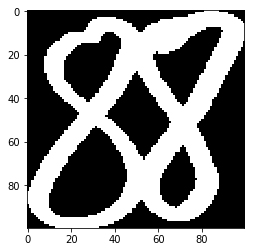

In [2]:
img_path = './toucing_digits_database/2002.png'

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.show()

In [3]:
# 实际上我们的素材就是二值化的图片
# 为了完整演示， 添加一个二值化的过程
_, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

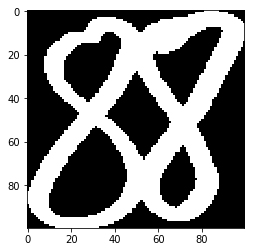

In [4]:
plt.imshow(bin_img, cmap='gray')
plt.show()

In [5]:
# 样本的尺寸
print(img.shape)

(100, 100)


## 垂直投影 获取直方图

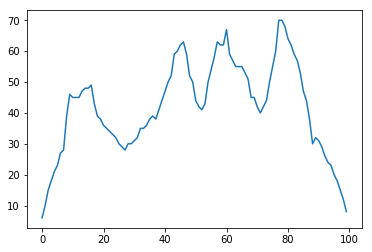

In [6]:
def binImgHist(img, bin_width=1, direction=1):
    '''
        二值化图像在y轴或者x轴方向的投影统计
    '''
    height, width = img.shape
    bins = None
    if direction == 0:
        # 在y轴方向上统计
        bins = int(height / bin_width)
    else:
        bins = int(width / bin_width)
    # 获取非零元素坐标
    nonzero_points = np.nonzero(img != 0)
    # 获取非零元素坐标中的x坐标集合或者y坐标集合
    nonzero_idx_x = nonzero_points[direction]
    #返回的统计直方图
    hist = np.histogram(np.int64(nonzero_idx_x), bins=bins)[0]
    
    return hist

bin_width = 1
hist = binImgHist(bin_img, bin_width=bin_width, direction=1)
plt.plot(hist)
plt.show()

## 确定水滴的下落起始点

接下来，我们需要寻找下落起始点，寻找水滴的下落点的策略有很多。例如从画面的width/2处开始，或者从左侧的峰值或者右侧的峰值滑落。
注意，滴水算法跟起始点有密切的关系， 分割效果的好坏，取决于以下两点：

* 下落点的位置的选择， 如果选择不好，容易将其中一个字符切开， 例如将0切成1。
* 倾斜角度， 倾斜角度小，分割效果就越好。

我们采用一个比较简单的方式来获取起始位置， **我们搜索宽度中心附近的几个点，找到最小值的那个坐标。**

In [7]:
height,width = img.shape
mid_x = int(width / 2)
search_win = 5

In [8]:
# 在中心区域内检索最小值，决定下落点 x坐标
start_x = np.argmin(hist[mid_x - search_win:mid_x + search_win + 1]) + (mid_x - search_win)

print(start_x)

52


## 制定下落规则

这里需要注意的是，我们这片文章中采用的是前景，笔画部分为逻辑1, 作者的论文里面用白色表示背景，黑色表示笔画部分,为远景表示法．
所以为了不引起混乱，　我们全局定义一个背景的颜色跟笔的颜色．


In [9]:
COLOR_BACK = 0 # 背景颜色
COLOR_PEN = 255 # 笔触的颜色

# 首先将原来的图片转换成布尔矩阵
bool_img = bin_img == COLOR_PEN

# 展示部分， 只有0跟1组成的矩阵
bool_img[45:50,45:50]

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

生成的布尔矩阵与下图的映射关系如下

* True -> Black 黑色　笔画的颜色
* False -> White 白色　背景色

滴水算法，本质上就是通过像素点周边的５个像素点的信息，来判断下一步所要选择的路径．
周边像素点，从左边开始，依次编号为 n1,n2,n3,n4,n5, 我们可以通过字典来存储编号与位置的映射关系．

```python
# 定义邻居坐标 的位置关系
NEIGHBOR_IDX = {
    1: (-1, 0),
    2: (-1, 1),
    3: (0, 1),
    4: (1, 1),
    5: (1, 0)
}
```

此截图来自与提出滴水算法的论文

接下来，就是制定一些规则来，决定下一个点往哪里走的问题，　下面我给出了完整详细的中文规则说明跟代码演示．
![Screenshot_20180316_031919.png](./image/Screenshot_20180316_031919.png)

为了避免混淆，我们不使用b跟w表示背景还是字符，改用字符颜色跟背景颜色。
总结规则如下：
* 优先级1： 全为背景或者全为笔迹 -> n3
* 优先级2： n2点为背景，且其他点至少有一个为笔迹的颜色　-> n2
* 优先级3: 左下角为笔迹的颜色，正下方为背景色 -> n3
* 优先级4: 左下角跟正下方为笔迹的颜色，右下方为背景色 ->n4
* 优先级5: 下方全为笔迹颜色，且左边为背景色 -> n5
* 优先级6: 除了左边是背景色，其他均为笔迹颜色 ->n1


周边一共有5个相关的像素点， 每个像素点有2种状态，所以总共的排列组合方法有$2^5 = 32$种可能的组合方式， 我们按照上述规则，遍历一遍所有的情况与对应的符合哪条处理规则信息。
其中**红色圆圈**代表当前的点。 **黑色跟蓝色**代表数字的像素部分(等同于上中的black)， 白色空白部分代表背景(等同于上面的white)。

彩笔标出来的数字，代表该情况是由哪个优先级所处理的。

![classical-big-fall-truth-table.jpg](./image/classical-big-fall-truth-table-0328.jpg)

不知道大家又没有注意到，在优先级5跟优先级6之间由一个**conditional test 条件测试**

原因是，存在一种特殊情况，可以让程序陷入死循环，见下图
![classical-big-fall-truth-table-0355－２.jpg](./image/classical-big-fall-truth-table-0355-2.jpg)

所以我们需要检测,该点又没有遍历过，　如果遍历过了，**说明当前存在一个障碍，阻挡水滴下落，我们需要进行渗透处理．**
所谓渗透就是向下钻．

可以选择在左边渗透或者在右边渗透：
![Screenshot_20180316_040617.png](./image/Screenshot_20180316_040617.png)

这里我们采用的是下面的那个方案．靠右下钻．
```python
# 判断点是否重复出现，左右往复平移
if next_pt in split_path:
    # 已经判断重复，进行渗透
    next_pt = (cur_pt[0],cur_pt[1]+1)
```


In [10]:
# 定义邻居坐标 的位置关系
NEIGHBOR_IDX = {
    1: (-1, 0),
    2: (-1, 1),
    3: (0, 1),
    4: (1, 1),
    5: (1, 0)
}

# 根据不同优先级情况，对应的下一个点的位置 n_i
CASE_NEXT_POINT = {
    1: 3,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 1
}

def is_case_p1(n1, n2, n3, n4, n5):
    '''
    优先级 ：１
    下落方向：　正下方
    下落位置： n3
    备注：　全为背景或者全为笔迹
    '''
    if n1 and n2 and n3 and n4 and n5 == True:
        # 全为数字部分
        return True
    elif not(n1) and not(n2) and not(n3) and not(n4) and not(n5) == True:
        # 全为背景部分
        return True 
    return False

def is_case＿p2(n1, n2, n3, n4, n5):
    '''
    优先级 ：２
    下落方向：　左下方
    下落位置： n2
    备注：　n2点为背景，且其他点至少有一个为笔迹的颜色
    '''
    return not(n2) and (n1 or n3 or n4 or n5)

def is_case_p3(n1, n2, n3, n4, n5):
    '''
    优先级 ：3
    下落方向：　正下方
    下落位置： n３
    备注：　左下角为笔迹的颜色，正下方为背景色
    '''
    return n2 and not(n3)
    
def is_case_p4(n1, n2, n3, n4, n5):
    '''
    优先级 ：4
    下落方向：右下方
    下落位置： n4
    备注：　左下角跟正下方为笔迹的颜色，右下方为背景色
    '''
    return n2 and n3 and not(n4)

def is_case_p5(n1, n2, n3, n4, n5):
    '''
    优先级 ：5
    下落方向：右边
    下落位置： n5
    备注：下方全为笔迹颜色，且左边为背景色
    '''
    return n2 and n3 and n4 and not(n5)

def is_case_p6(n1, n2, n3, n4, n5):
    '''
    优先级 6
    下落方向：左边
    下落点：n1
    备注　除了左边是背景色，其他均为笔迹颜色
    '''
    return not(n1) and n2 and n3 and n4 and n5


def drop_fall(neighbors):
    '''
    传统滴水算法　　核心代码
    根据优先级实现
    neighbors = [n1, n2, n3, n4, n5]
    
    返回 ：下落点的邻居编号
    '''
    
    for priority in range(1,7):
        if eval('is_case_p{}(*neighbors)'.format(priority)):
            return CASE_NEXT_POINT[priority]
     
    
    

In [11]:
def is_legal_pt(img, x, y):
    '''
    是否为合法的坐标
    判断是否超出正常的数值范围
    '''
    h,w = img.shape
    if x < 0 or y < 0 or x >= w or y>= h:
        return False
    return True

def get_neighbors(bool_img, x, y):
    '''
    给定逻辑图跟坐标， 返回邻居的有序布尔数组
    '''
    neighbors = []
    for n_idx in range(1, 6):
        dx,dy = NEIGHBOR_IDX[n_idx]
        new_x, new_y = x + dx, y + dy
        if not is_legal_pt(bool_img, new_x, new_y):
            # 如果坐标不合法 填充背景
            neighbors.append(False)
        else:
            neighbors.append(bool_img[new_y][new_x])
    # print(neighbors)
    return neighbors

In [12]:
def get_split_path(bool_img, start_x):
    '''
    给出分割路径
    '''
    height, width = bool_img.shape # 获取图像的高度跟宽度
    min_x = 0 # x坐标的左边界
    max_x = width - 1 # x坐标的右边界
    max_y = height - 1
    # 当前的点
    cur_pt = (start_x, 0)
    # 最近的点
    last_pt = cur_pt
    # 分割路径
    split_path = [cur_pt]
    
    while cur_pt[1] < max_y:
        neighbors = get_neighbors(bool_img, cur_pt[0], cur_pt[1])
        n_idx = drop_fall(neighbors)
        dx, dy = NEIGHBOR_IDX[n_idx]
        next_pt = None
        next_x,next_y = cur_pt[0]+dx, cur_pt[1]+dy
        if not is_legal_pt(bool_img, next_x, next_y):
            # x/y越界 向下渗透
            next_pt = (cur_pt[0],cur_pt[1]+1)
        else:
            next_pt = (next_x, next_y)
        # 判断点是否重复出现，左右往复平移
        if next_pt in split_path:
            # 已经判断重复，进行渗透
            next_pt = (cur_pt[0],cur_pt[1]+1)
        
        cur_pt = next_pt
        split_path.append(cur_pt)
    return split_path

## 字符分割效果展示

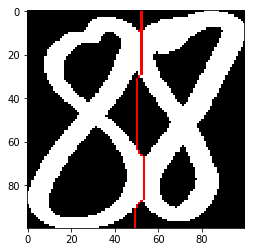

In [13]:
def view_split_result(img, split_path):
    canvas = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for (x, y) in split_path:
        canvas[y][x] = (0,0,255)
    return canvas

split_path = get_split_path(bool_img, start_x)
canvas = view_split_result(img, split_path)

plt.imshow(canvas[:,:,::-1])
plt.show()

## 总结
你也可以换用样本库中的其他训练数据，查看字符分割效果，总之，滴水算法就是这么一个优美的算法．但是也不是没有瑕疵的，　例如它对与倾斜角度较大的字符分割效果就会很差，而且只参考周边5个像素点，容易受噪声干扰．在滴水算法的基础上，后面又诞生了**带惯性的大水滴滴水算法**.感兴趣的同学可以阅读一下附件中的论文　**Inertial and Big Drop Fall Algorithm ** 作者是北京邮电大学的　Xiujuan Wang.
建议你尝试阅读下论文，并用Python实现此算法．